In [1]:

from find_prices_nonoverlap import *
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
import warnings
warnings.filterwarnings(action='once')

Preparing Data: cleaning data
Preparing Data: splitting test/train/validation


In [2]:
from sklearn.ensemble import AdaBoostRegressor

In [25]:
df = pd.read_csv('single_family_home_values.csv')


print('Preparing Data: cleaning data')
not_useful_fields = ['id','city','state', 'address']
date_fields = ['lastSaleDate', 'priorSaleDate']
required_fields = ['latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt',
                   'lastSaleDate','estimated_value']
zero_to_nan_fields = None
remove_outliers=False
df2 = prepare_data(df, not_useful_fields=not_useful_fields,
        date_fields=date_fields,
        remove_outliers=remove_outliers,
        required_fields=required_fields,
        zero_to_nan_fields=zero_to_nan_fields,
        )

print('Preparing Data: splitting test/train/validation')
df_train, df_test, df_validation = train_validate_test_split(df2)

X_test = df_test[df_test.columns.drop('estimated_value')]
y_test = df_test['estimated_value']
# y_test = np.log(df_test['estimated_value'] + 1)

X = df_train[df_train.columns.drop('estimated_value')]
y = df_train['estimated_value'] 
# y = np.log(df_train['estimated_value'] + 1)

Preparing Data: cleaning data
Preparing Data: splitting test/train/validation


In [15]:

from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor 
)

print("Setting up pipeline")
features = ('latitude', 'longitude',# 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear','lastSaleDateMonth','lastSaleDateDayOfWeek')
#'yearBuilt', 'lastSaleDayOfWeek','lastSaleWeekOfYear','lastSaleMonth','LastSaleYear',
# features = required_fields

#: Note imputer will strip away column heads, it has to be after featurize
# reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
reg_function = RandomForestRegressor(n_jobs=3)
#reg_function = GradientBoostingRegressor()
# reg_function = ExtraTreesRegressor(n_estimators=2)
# reg_function = AdaBoostRegressor(); #Really bad
pipeline = Pipeline([
          ('featurize', featurize(features)),
          ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
          ('forest', reg_function,)
            ])


Setting up pipeline


Fitting model on training data
Evaluating model on training data
67940.6011893
29450.5555729
0.9826834573
0.0419643887431


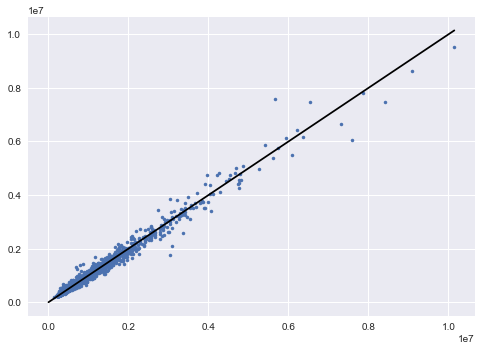

Evaluating model on testing data
145180.551473
73136.3498665
0.913130082275
0.105277324251


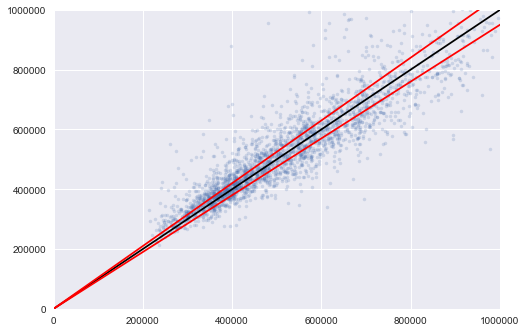

In [26]:
def print_metrics(y, y_pred):
#     y = np.exp(y)
#     y_pred = np.exp(y_pred)
    print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
    print(metrics.mean_absolute_error(y,y_pred))
    print(metrics.r2_score(y,y_pred))
    print(abs_mean_relative_error(y,y_pred))
    
print("Fitting model on training data")
model = pipeline.fit(X = X, y = y)

print("Evaluating model on training data")
y_pred = model.predict(X)
print_metrics(y, y_pred)
plt.plot((y), (y_pred),'.')
y_max = (np.max((y, y_pred)))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

print("Evaluating model on testing data")
y_test_pred = model.predict(X_test)
print_metrics(y_test, y_test_pred)
plt.plot((y_test), (y_test_pred),'.', alpha=0.2)
y_max = (np.max((y_test, y_test_pred)))
plt.plot((0,y_max), (0,y_max),color='black')
plt.plot((0,y_max), (0,y_max*1.05),color='red')
plt.plot((0,y_max), (0,y_max*0.95),color='red')
plt.xlim(0,1e6)
plt.ylim(0,1e6)
plt.show()

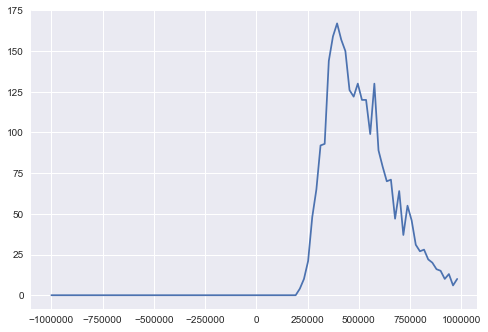

In [6]:
[c,b] = np.histogram(y_pred-y, bins=np.linspace(-1e6,1e6,100))
plt.plot(b[:-1],c)
plt.show()

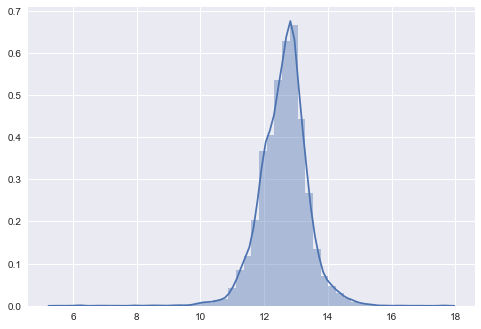

In [7]:

sns.distplot(np.log(df['lastSaleAmount'].values+1))
plt.show()


In [8]:
#: Work on using grid-searches
params = {'forest__n_estimators':  (39,42)}
# params = {'forest__n_estimators':  np.arange(3,31,3)}
from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)
# transformer.transform(y)
grid = GridSearchCV(pipeline, params)
grid.fit(X = X, y = y)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(pipeline, params)#, cv=cv)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = X, y = y)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=42, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [9]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=42, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [10]:
# cross_val_score(pipeline, X, y, 'accuracy')

0.056388144028
0.0390516443611
0.985040520052
0.00293733649874


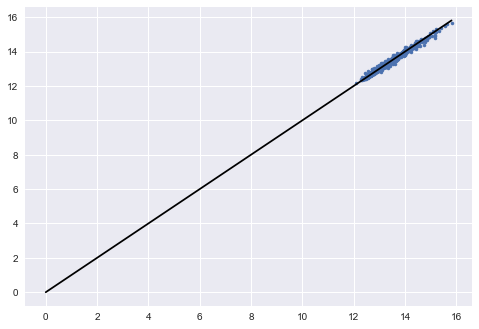

In [11]:
X = X_test
y=y_test
y_pred = best_pipeline.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(metrics.r2_score(y,y_pred))
print(abs_mean_relative_error(y,y_pred))
plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

In [12]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.32964039,  0.32983669]),
 'mean_score_time': array([ 0.12278938,  0.11657794]),
 'mean_test_score': array([ 0.89138882,  0.89256321]),
 'mean_train_score': array([ 0.98421036,  0.98405507]),
 'param_forest__n_estimators': masked_array(data = [39 42],
              mask = [False False],
        fill_value = ?),
 'params': ({'forest__n_estimators': 39}, {'forest__n_estimators': 42}),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_test_score': array([ 0.88842577,  0.89136369]),
 'split0_train_score': array([ 0.98449992,  0.9836034 ]),
 'split1_test_score': array([ 0.89451099,  0.89321828]),
 'split1_train_score': array([ 0.984484  ,  0.98448863]),
 'split2_test_score': array([ 0.89122953,  0.89310821]),
 'split2_train_score': array([ 0.98364716,  0.98407318]),
 'std_fit_time': array([ 0.00138624,  0.02191972]),
 'std_score_time': array([ 0.00467966,  0.00018372]),
 'std_test_score': array([ 0.00248724,  0.00084959]),
 'std_train_score': array([ 0.0003

In [13]:
pipeline.steps[2][1].feature_importances_

array([ 0.04326373,  0.00414483,  0.01642187,  0.00760086,  0.5767813 ,
        0.02979906,  0.32198834])